# Few Shot Sampling of Blood Smear Images

## Custom Dataloader

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:

def resize_and_pad(image, target_size=(320, 320), fill=0):
    """
    Resize an image to fit within the target size while preserving the aspect ratio,
    then pad the shorter sides with a constant value to reach the target size.

    Args:
        image (PIL.Image): Input image.
        target_size (tuple): Target size (width, height), default (224, 224).
        fill (int or tuple): Padding fill value (e.g., 0 for black, 255 for white).

    Returns:
        PIL.Image: Resized and padded image of size target_size.
    """
    # Get original dimensions
    width, height = image.size
    target_width, target_height = target_size

    # Calculate scaling factor to fit within target size
    scale = min(target_width / width, target_height / height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Resize image with correct (height, width) order
    resized_image = transforms.functional.resize(image, (new_height, new_width))

    # Calculate padding to center the image
    padding_left = (target_width - new_width) // 2
    padding_top = (target_height - new_height) // 2
    # Ensure padding adds up exactly to the difference
    padding_right = target_width - new_width - padding_left
    padding_bottom = target_height - new_height - padding_top

    # Apply padding
    padded_image = transforms.functional.pad(
        resized_image,
        padding=(padding_left, padding_top, padding_right, padding_bottom),
        fill=fill
    )

    return padded_image

In [3]:
# Basic Image transformation
def get_base_transforms(target_size=(320, 320), use_grayscale=False):
    """
    Returns a composed set of basic image transformations for preprocessing input images.

    Parameters:
    - target_size (tuple): The desired output size (height, width) of the image after resizing and padding.
    - use_grayscale (bool): If True, converts the image to grayscale with 3 channels before applying other transformations.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Optional grayscale conversion with 3 output channels,
        - Resizing and padding the image to match the target size,
        - Conversion to tensor,
        - Normalization using ImageNet mean and standard deviation.
    """
    base_transforms = [
        transforms.Lambda(lambda img: resize_and_pad(img, target_size=target_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    if use_grayscale:
        base_transforms.insert(0, transforms.Grayscale(num_output_channels=3))  # Keep 3 channels for compatibility
    return transforms.Compose(base_transforms)


# Data augmentation transforms
def get_augmentation_transforms():
    """
    Returns a composed set of data augmentation transformations to artificially expand the training dataset.

    This function applies a series of random transformations to simulate variations in brightness, contrast, orientation,
    and color mode, helping the model generalize better.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Random brightness and contrast adjustment (ColorJitter),
        - Random horizontal and vertical flipping,
        - Random rotation by up to ±10 degrees,
        - Random conversion to grayscale with a 20% probability.
    """
    return transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Simulate lighting/stain variations
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(p=0.2)  # Optional: Randomly apply grayscale as part of augmentation
    ])


In [4]:
class FewShotDataset(Dataset):
    def __init__(self, data_dir, split, num_ways=5, num_support=5,
                 num_query=10, num_episodes=100, target_size=(320, 320),
                 use_grayscale=False,
                 augment=False,
                 ):
        """
        Args:
            data_dir (str): Path to dataset directory
            split (str): One of 'train', 'validation', or 'test'
            num_ways (int): Number of classes per episode
            num_support (int): Number of support samples per class (i.e. number of shots)
            num_query (int): Number of query samples per class
            num_episodes (int): Number of episodes per epoch
            use_grayscale(bool),  Use grayscale or not
            augment(bool),        For data augmentation technique
        """
        self.split_dir = os.path.join(data_dir, split)
        self.num_ways = num_ways
        self.num_support = num_support
        self.num_query = num_query
        self.num_episodes = num_episodes
        base_transform = get_base_transforms(target_size, use_grayscale)
        if augment:
            augmentation_transform = get_augmentation_transforms()
            self.transform = transforms.Compose([augmentation_transform, base_transform])
        else:
            self.transform = base_transform

        # Load class directories and their images
        self.classes = [c for c in os.listdir(self.split_dir)
                       if os.path.isdir(os.path.join(self.split_dir, c))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map class names to indices
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}  # Map indices to class names
        self.class_images = {
            c: [os.path.join(self.split_dir, c, img)
                for img in os.listdir(os.path.join(self.split_dir, c))]
            for c in self.classes
        }

    def __len__(self):
        return self.num_episodes

    def __getitem__(self, index):
        # Randomly select N classes for this episode
        selected_classes = np.random.choice(self.classes, self.num_ways, replace=False)

        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        for label_idx, class_name in enumerate(selected_classes):
            all_images = self.class_images[class_name]
            if len(all_images) < self.num_support + self.num_query:
                raise ValueError(
                    f"Class {class_name} has only {len(all_images)} images. "
                    f"Need at least {self.num_support + self.num_query}."
                )

            # Randomly select support and query images
            selected_indices = np.random.choice(
                len(all_images),
                self.num_support + self.num_query,
                replace=False #True#########################################################################
            )
            support_paths = [all_images[i] for i in selected_indices[:self.num_support]]
            query_paths = [all_images[i] for i in selected_indices[self.num_support:]]

            # Load and transform support images
            for path in support_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                support_images.append(img)
                support_labels.append(label_idx)

            # Load and transform query images
            for path in query_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                query_images.append(img)
                query_labels.append(label_idx)

        # Shuffle the support and query sets
        support_indices = np.arange(len(support_images))
        query_indices = np.arange(len(query_images))
        np.random.shuffle(support_indices)
        np.random.shuffle(query_indices)

        support_images = [support_images[i] for i in support_indices]
        support_labels = [support_labels[i] for i in support_indices]
        query_images = [query_images[i] for i in query_indices]
        query_labels = [query_labels[i] for i in query_indices]

        # Convert lists to tensors
        support_set = (
            torch.stack(support_images),
            torch.tensor(support_labels, dtype=torch.long)
        )
        query_set = (
            torch.stack(query_images),
            torch.tensor(query_labels, dtype=torch.long)
        )
        # Store the selected class names for this episode
        selected_classes = [str(cls) for cls in selected_classes]
        episode_classes = selected_classes

        return support_set, query_set, episode_classes

In [5]:
def get_data_loader(dataset, batch_size=1, shuffle=True):
    """
    Returns DataLoader for the dataset.
    Note: Batch size should typically be 1 for few-shot learning,
    as each episode is a separate task.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

## Modelling

### Semantic

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from transformers import BertTokenizer, BertModel
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- BioBERT for Disease Embeddings ---
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
bert_model = BertModel.from_pretrained('dmis-lab/biobert-v1.1').to(device)

def get_disease_embedding(disease_name):
    """Get BioBERT embedding for a disease name."""
    inputs = tokenizer(disease_name, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()  # [768]



In [7]:
# --- Clinical Features ---
# One-hot encoding for cell shape: [round, elongated, irregular, other]
clinical_features = {
    'iron_deficiency_anemia': torch.tensor([0, 1, 0, 0], dtype=torch.float),  # Elongated
    'rouleaux_formation': torch.tensor([0, 0, 0, 1], dtype=torch.float),      # Other (stacked)
    'essential_thrombocytopemia': torch.tensor([0, 0, 0, 1], dtype=torch.float),  # Other
    'hypersegmented_neutrophils': torch.tensor([0, 0, 1, 0], dtype=torch.float),      # Irregular
    'myelodysplastic_syndrome_buyomes': torch.tensor([0, 0, 1, 0], dtype=torch.float), # Irregular
    'platelet_clumps': torch.tensor([0, 0, 0, 1], dtype=torch.float),         # Other
    'myeloid_leukemia': torch.tensor([0, 0, 1, 0], dtype=torch.float),        # Irregular
    'filariasis': torch.tensor([0, 0, 0, 1], dtype=torch.float),              # Other
    'howell_jolly_bodies': torch.tensor([0, 0, 1, 0], dtype=torch.float),     # Irregular
    'chronic_lymphocytic_leukemia': torch.tensor([0, 0, 1, 0], dtype=torch.float), # Irregular
    'neutropenia': torch.tensor([0, 0, 0, 1], dtype=torch.float),             # Other
    'schistocytes': torch.tensor([0, 0, 1, 0], dtype=torch.float),            # Irregular
    'immune_thrombocytopenic_purpura': torch.tensor([0, 0, 0, 1], dtype=torch.float), # Other
    'basophilic_stippling': torch.tensor([0, 0, 1, 0], dtype=torch.float),    # Irregular
    'hemophagocytic_lymphohistiocytosis': torch.tensor([0, 0, 0, 1], dtype=torch.float), # Other
    'target_cells': torch.tensor([1, 0, 0, 0], dtype=torch.float),            # Round
    'spherocytosis': torch.tensor([1, 0, 0, 0], dtype=torch.float),           # Round
    'reticulocytosis': torch.tensor([0, 0, 0, 1], dtype=torch.float),         # Other
    'babesiosis': torch.tensor([0, 0, 0, 1], dtype=torch.float),              # Other
    'myelofibrosis': torch.tensor([0, 0, 0, 1], dtype=torch.float),           # Other
    'giant_platelets': torch.tensor([0, 0, 0, 1], dtype=torch.float),         # Other
    'chronic_myelogenous_leukemia': torch.tensor([0, 0, 1, 0], dtype=torch.float), # Irregular
    'basophilic': torch.tensor([0, 0, 0, 1], dtype=torch.float),               # Other (staining property)
    'ehrlichiosis': torch.tensor([0, 0, 0, 1], dtype=torch.float),            # Other
    'elliptocytes_ovalocytes': torch.tensor([0, 1, 0, 0], dtype=torch.float), # Elongated
    'atypical_lymphocytes': torch.tensor([0, 0, 1, 0], dtype=torch.float), # Irregular
    'hemolytic_uremic_syndrome': torch.tensor([0, 0, 1, 0], dtype=torch.float), # Irregular
    'anaplasmosis': torch.tensor([0, 0, 0, 1], dtype=torch.float),            # Other
    'malaria': torch.tensor([0, 0, 0, 1], dtype=torch.float),                 # Other
    'sickle_cell': torch.tensor([0, 1, 0, 0], dtype=torch.float),      # Elongated
    'trypanosomiasis': torch.tensor([0, 0, 0, 1], dtype=torch.float),         # Other
    'leukemia': torch.tensor([0, 0, 1, 0], dtype=torch.float)                 # Irregular
}

In [8]:
# --- Dataset ---
class FewShotDataset(Dataset):
    def __init__(self, data_dir, split, num_ways=5, num_support=5,
                 num_query=10, num_episodes=100, target_size=(320, 320), augment=False):
        self.split_dir = os.path.join(data_dir, split)
        self.num_ways = num_ways
        self.num_support = num_support
        self.num_query = num_query
        self.num_episodes = num_episodes
        base_transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        if augment:
            augmentation_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
            ])
            self.transform = transforms.Compose([augmentation_transform, base_transform])
        else:
            self.transform = base_transform

        self.classes = [c for c in os.listdir(self.split_dir)
                        if os.path.isdir(os.path.join(self.split_dir, c))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.class_images = {
            c: [os.path.join(self.split_dir, c, img)
                for img in os.listdir(os.path.join(self.split_dir, c))]
            for c in self.classes
        }
        # Semantic embeddings and clinical features
        self.class_embeddings = {cls: get_disease_embedding(cls) for cls in self.classes}

        # Find and print classes not in clinical_features
        missing_classes = [cls for cls in self.classes if cls not in clinical_features]
        if missing_classes:
            print("Classes not found in clinical_features:", missing_classes)

        self.class_clinical = {cls: clinical_features.get(cls, torch.zeros(4, dtype=torch.float)) for cls in self.classes}

    def __len__(self):
        return self.num_episodes

    def __getitem__(self, index):
        selected_classes = np.random.choice(self.classes, self.num_ways, replace=False)
        support_images, support_labels = [], []
        query_images, query_labels = [], []
        selected_embeddings = []
        selected_clinical = []

        for label_idx, class_name in enumerate(selected_classes):
            all_images = self.class_images[class_name]
            if len(all_images) < self.num_support + self.num_query:
                raise ValueError(f"Class {class_name} has insufficient images.")
            selected_indices = np.random.choice(len(all_images), self.num_support + self.num_query, replace=False)
            support_paths = [all_images[i] for i in selected_indices[:self.num_support]]
            query_paths = [all_images[i] for i in selected_indices[self.num_support:]]

            for path in support_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                support_images.append(img)
                support_labels.append(label_idx)

            for path in query_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                query_images.append(img)
                query_labels.append(label_idx)

            selected_embeddings.append(self.class_embeddings[class_name])
            selected_clinical.append(self.class_clinical[class_name])

        support_indices = np.random.permutation(len(support_images))
        query_indices = np.random.permutation(len(query_images))
        support_images = [support_images[i] for i in support_indices]
        support_labels = [support_labels[i] for i in support_indices]
        query_images = [query_images[i] for i in query_indices]
        query_labels = [query_labels[i] for i in query_indices]

        support_set = (torch.stack(support_images), torch.tensor(support_labels, dtype=torch.long))
        query_set = (torch.stack(query_images), torch.tensor(query_labels, dtype=torch.long))
        embeddings = torch.stack(selected_embeddings)  # [num_ways, 768]
        clinical = torch.stack(selected_clinical)      # [num_ways, clinical_dim]
        return support_set, query_set, embeddings, clinical

def get_data_loader(dataset, batch_size=1, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=0,
                      pin_memory=False)



In [9]:
# --- Model ---
class SemanticPrototypicalNetwork(nn.Module):
    def __init__(self, backbone, semantic_dim=768,
                 clinical_dim=4, fusion_dim=2048,
                 dropout_p=0.2):
        super().__init__()
        self.backbone = backbone
        self.backbone.fc = nn.Identity()  # Remove original classifier
        self.semantic_proj = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(semantic_dim, fusion_dim)
        )
        self.clinical_proj = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(clinical_dim, fusion_dim)
        )
        self.visual_proj = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(2048, fusion_dim)
        )

    def forward(self, support_images, support_labels, query_images, class_embeddings, class_clinical):
        # Extract visual features
        support_features = self.backbone(support_images)  # [N_s, 2048]
        query_features = self.backbone(query_images)      # [N_q, 2048]

        # Project features
        support_features_proj = self.visual_proj(support_features)  # [N_s, fusion_dim]
        query_features_proj = self.visual_proj(query_features)      # [N_q, fusion_dim]
        class_embeddings_proj = self.semantic_proj(class_embeddings)  # [num_ways, fusion_dim]
        class_clinical_proj = self.clinical_proj(class_clinical)      # [num_ways, fusion_dim]

        # Compute visual prototypes
        unique_labels = torch.unique(support_labels)
        visual_prototypes = []
        for label in unique_labels:
            mask = support_labels == label
            proto = support_features_proj[mask].mean(dim=0)
            visual_prototypes.append(proto)
        visual_prototypes = torch.stack(visual_prototypes)  # [num_ways, fusion_dim]

        # Fuse with semantic and clinical features
        fused_prototypes = visual_prototypes + class_embeddings_proj + class_clinical_proj  # Simple addition

        # Compute distances
        distances = torch.cdist(query_features_proj, fused_prototypes)  # [N_q, num_ways]
        return -distances  # Logits



In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# --- Training and Evaluation ---
# data_dir = "/content/drive/MyDrive/Computer vision with few shot sampling focus group/data_set"  # Update this path
data_dir = "/home/ifihan/multi-dease-detection/data_set"

# Training dataset
train_dataset = FewShotDataset(
    data_dir=data_dir,
    split="train",
    num_ways=5,
    num_support=5,
    num_query=15,
    num_episodes=500,
    augment=True
)

val_dataset = FewShotDataset(
    data_dir=data_dir,
    split="test",  # Use 'test' split for validation
    num_ways=min(5, len(os.listdir(os.path.join(data_dir, "test")))),
    num_support=5,
    num_query=15,
    num_episodes=300,  # Fewer episodes for validation
    augment=False
)

train_loader = get_data_loader(train_dataset)
val_loader = get_data_loader(val_dataset)

# Initialize model
backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = SemanticPrototypicalNetwork(backbone, dropout_p=0.2).to(device)
criterion = nn.CrossEntropyLoss()


# Allow finetuning of backbone (unfreeze)
for param in model.backbone.parameters():
    param.requires_grad = True

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


Validation: 100%|██████████| 300/300 [04:01<00:00,  1.24episode/s, acc=0.25, loss=2.58]


Epoch 1/100, Train Loss: 2.5185, Train Acc: 0.2113, Val Loss: 2.6857, Val Acc: 0.2500
Saved best model to /home/ifihan/multi-dease-detection/best_semantic_model.pth


Validation: 100%|██████████| 300/300 [04:00<00:00,  1.25episode/s, acc=0.35, loss=2.07] 


Epoch 2/100, Train Loss: 1.7341, Train Acc: 0.3362, Val Loss: 2.1961, Val Acc: 0.3790
Saved best model to /home/ifihan/multi-dease-detection/best_semantic_model.pth


Validation: 100%|██████████| 300/300 [03:55<00:00,  1.27episode/s, acc=0.483, loss=2.25]


Epoch 3/100, Train Loss: 1.5166, Train Acc: 0.4155, Val Loss: 2.4911, Val Acc: 0.3911


Validation: 100%|██████████| 300/300 [03:53<00:00,  1.28episode/s, acc=0.4, loss=2.3]   


Epoch 4/100, Train Loss: 1.1782, Train Acc: 0.5543, Val Loss: 2.1739, Val Acc: 0.3850
Saved best model to /home/ifihan/multi-dease-detection/best_semantic_model.pth


Validation: 100%|██████████| 300/300 [04:07<00:00,  1.21episode/s, acc=0.483, loss=2.17]


Epoch 5/100, Train Loss: 0.9181, Train Acc: 0.6580, Val Loss: 2.1457, Val Acc: 0.4773
Saved best model to /home/ifihan/multi-dease-detection/best_semantic_model.pth


Validation: 100%|██████████| 300/300 [03:55<00:00,  1.27episode/s, acc=0.467, loss=1.79]


Epoch 6/100, Train Loss: 0.6505, Train Acc: 0.7652, Val Loss: 2.2289, Val Acc: 0.4591


Validation: 100%|██████████| 300/300 [03:59<00:00,  1.25episode/s, acc=0.55, loss=1.91] 


Epoch 7/100, Train Loss: 0.4252, Train Acc: 0.8463, Val Loss: 2.4231, Val Acc: 0.4579


Validation: 100%|██████████| 300/300 [04:00<00:00,  1.25episode/s, acc=0.45, loss=1.78] 


Epoch 8/100, Train Loss: 0.3047, Train Acc: 0.8919, Val Loss: 2.3441, Val Acc: 0.4233


Validation: 100%|██████████| 300/300 [03:55<00:00,  1.28episode/s, acc=0.6, loss=2.02]  


Epoch 9/100, Train Loss: 0.2214, Train Acc: 0.9236, Val Loss: 2.3604, Val Acc: 0.4965


Validation: 100%|██████████| 300/300 [04:07<00:00,  1.21episode/s, acc=0.467, loss=2.01]


Epoch 10/100, Train Loss: 0.0660, Train Acc: 0.9755, Val Loss: 2.3635, Val Acc: 0.4854
Early stopping at epoch 10


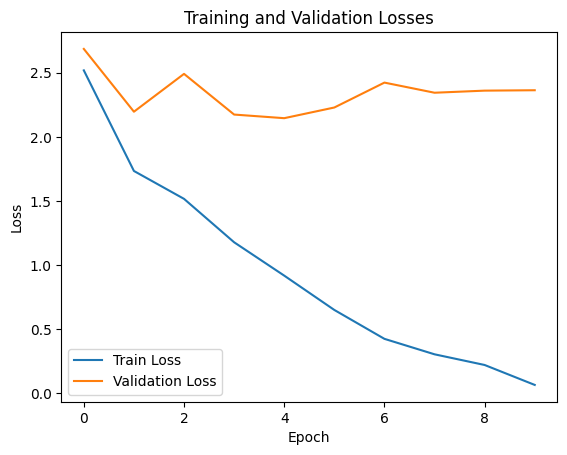

In [12]:
# Training loop
best_acc = 0.0  # Initialize best accuracy
# best_model_path = "/content/drive/MyDrive/Computer vision with few shot sampling focus group/best_semantic_model.pth"
best_model_path = "/home/ifihan/multi-dease-detection/best_semantic_model.pth"
num_epochs = 100
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    # Training loop with tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="episode") as tepoch:
        for support_set, query_set, embeddings, clinical in train_loader:
            support_images, support_labels = support_set
            query_images, query_labels = query_set
            embeddings = embeddings.to(device)
            clinical = clinical.to(device)

            support_images = support_images.to(device)
            support_labels = support_labels.to(device)
            query_images = query_images.to(device)
            query_labels = query_labels.to(device)

            if support_images.dim() == 5:
                support_images = support_images.squeeze(0)
            if query_images.dim() == 5:
                query_images = query_images.squeeze(0)
            if support_labels.dim() == 2:
                support_labels = support_labels.squeeze(0)
            if query_labels.dim() == 2:
                query_labels = query_labels.squeeze(0)

            optimizer.zero_grad()
            logits = model(support_images, support_labels, query_images, embeddings, clinical)
            logits = logits.view(-1, logits.shape[-1])  # Reshape logits
            loss = criterion(logits, query_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            acc = (preds == query_labels).float().mean()
            train_acc += acc.item()
            tepoch.set_postfix(loss=loss.item(), acc=acc.item())  # Update progress bar

    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Store training loss
    train_acc /= len(train_loader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():  # Disable gradient calculations during validation
        with tqdm(val_loader, desc="Validation", unit="episode") as vepoch:  # Progress bar for validation
            for support_set, query_set, embeddings, clinical in vepoch:
                support_images, support_labels = support_set
                query_images, query_labels = query_set
                embeddings = embeddings.to(device)
                clinical = clinical.to(device)

                support_images = support_images.to(device)
                support_labels = support_labels.to(device)
                query_images = query_images.to(device)
                query_labels = query_labels.to(device)

                # Remove extra batch dimension if present
                if support_images.dim() == 5:
                    support_images = support_images.squeeze(0)
                if query_images.dim() == 5:
                    query_images = query_images.squeeze(0)
                if support_labels.dim() == 2:
                    support_labels = support_labels.squeeze(0)
                if query_labels.dim() == 2:
                    query_labels = query_labels.squeeze(0)

                logits = model(support_images, support_labels, query_images, embeddings, clinical)
                logits = logits.view(-1, logits.shape[-1])  # Reshape logits
                loss = criterion(logits, query_labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                acc = (preds == query_labels).float().mean()
                val_acc += acc.item()

                vepoch.set_postfix(loss=loss.item(), acc=acc.item())  # Update progress bar

    val_loss /= len(val_loader)  # Average validation loss
    val_acc /= len(val_loader)   # Average validation accuracy
    val_losses.append(val_loss)  # Store validation loss

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model to {best_model_path}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_loss)  # Schedule learning rate based on validation loss

# Plotting losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()


In [13]:
# Load the trained model (adjust the path to your saved model)
# model.load_state_dict(torch.load("/content/drive/MyDrive/Computer vision with few shot sampling focus group/best_semantic_model.pth"))  # Ensure this file exists

# Evaluate 1-shot, 5-shot, 10-shot
test_shots = [1, 5, 10]
for num_shots in test_shots:
    test_dataset = FewShotDataset(
        data_dir=data_dir,
        split="test",
        num_ways=4,  # 4 test diseases
        num_support=num_shots,
        num_query=10,
        num_episodes=300,
        augment=False
    )
    test_loader = get_data_loader(test_dataset)

    model.eval()
    episode_accuracies = []  # List to store accuracy for each episode
    with torch.no_grad():
        for support_set, query_set, embeddings, clinical in test_loader:
            support_images, support_labels = support_set
            query_images, query_labels = query_set
            embeddings = embeddings.to(device)
            clinical = clinical.to(device)

            support_images = support_images.to(device)
            support_labels = support_labels.to(device)
            query_images = query_images.to(device)
            query_labels = query_labels.to(device)

            # Remove extra batch dimension if present
            if support_images.dim() == 5:
                support_images = support_images.squeeze(0)
            if query_images.dim() == 5:
                query_images = query_images.squeeze(0)
            if support_labels.dim() == 2:
                support_labels = support_labels.squeeze(0)
            if query_labels.dim() == 2:
                query_labels = query_labels.squeeze(0)

            logits = model(support_images, support_labels, query_images, embeddings, clinical)
            logits = logits.view(-1, logits.shape[-1])  # Reshape logits
            preds = torch.argmax(logits, dim=1)
            acc = (preds == query_labels).float().mean()
            episode_accuracies.append(acc.item())  # Store episode accuracy

    # Compute mean accuracy and standard deviation
    mean_acc = np.mean(episode_accuracies)
    std_acc = np.std(episode_accuracies)
    print(f"{num_shots}-Shot Test Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

1-Shot Test Accuracy: 0.4371 ± 0.0819
5-Shot Test Accuracy: 0.4828 ± 0.0621
10-Shot Test Accuracy: 0.4839 ± 0.0594
